# PMOIRED example #2: FU Ori (GRAVITY)

Based on GRAVITY spectro-inteforometric data presented in [Liu et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884...97L/abstract). This example developes more advanced use of MOIRE: 

- Loading oifits files containing more than one instrument
- Displaying chromatic data as function of wavelength
- How to combine components to make a complex model, with chromatic variation 

*https://github.com/amerand/PMOIRED - Antoine Mérand (amerand@eso.org)*

In [1]:
%pylab notebook
import time, os, pickle
try:
    # -- global installation
    import pmoired
    print('global')
except:
    # -- local installation
    import sys
    sys.path = ['../pmoired'] + sys.path
    import __init__ as pmoired
    print('local')

Populating the interactive namespace from numpy and matplotlib
[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
local


## List and load data
OIFITS files can contain data from different targets and instruments. The constructor for `OI` can be set to load data from a specific instrument / target by using keyword arguments `insname` and `targname`. If the file contain more than one target and no `targname` is specified, then the loading will fail. On the other hand, if a single target is present but many instruments, all instruments will be loaded in separate dictionnaries.

In [2]:
directory = './FUOri'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('singlesciviscalibrated.fits')]
# -- load only spectrograph
oi = pmoired.OI(files, insname='GRAVITY_SC')

loadOI: loading ./FUOri/GRAVI.2016-11-25T06:27:33.893_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "FU_Ori" pipeline: "GRAVITY Instrument Pipeline 1.0.11"
  > MJD: [57717.27102101271]
  > D0-G2-J3-K0 | WL: (210,) 1.99 to 2.45 um | ['OI_FLUX', 'OI_T3', 'OI_VIS', 'OI_VIS2'] | TELLURICS: True
loadOI: loading ./FUOri/GRAVI.2016-11-25T06:39:21.933_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "FU_Ori" pipeline: "GRAVITY Instrument Pipeline 1.0.11"
  > MJD: [57717.27925017938]
  > D0-G2-J3-K0 | WL: (210,) 1.99 to 2.45 um | ['OI_FLUX', 'OI_T3', 'OI_VIS', 'OI_VIS2'] | TELLURICS: True


## Fit a complex model 
The model is composed of two components: a "compact" component and a "resolved" one. Making a composite model is very easy to achieve: the model is still described by a dictionnary, but parameters are grouped by components as `component,param`.

The compat component is used as the phase and flux reference: it has central position `x, y = 0, 0` (because by default, if no position is give, it will be placed at '0,0'). We have to fix the flux somehow, since interferometry if not sensitive to absolute fluxes. This is achieved by adding `compact,f0` to `doNotFit`. 

When we look at the result with the `show` method, we can display all data (`allInOne=True`) with the model as function of the wavelength (i.e. `spectro=True`, set automatically). A synthetic image is computed when a field-of-view `imFov` and pixel size `imPix` are given (both in mas). In this particular case, the extended component has very low surface brightness. To make is visible in the synthetic image, the image is shown only between 0 and `imMax=0.002`.

[dpfit] 6 FITTED parameters: ['compact,ud', 'resolved,F0', 'resolved,F2', 'resolved,fwhm', 'resolved,x', 'resolved,y']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 51
[dpfit] time per function call: 21.95 (ms)
------------------------------
        CHI2= 3466.1805269391234
REDUCED CHI2= 0.9543448587387454
------------------------------
(uncertainty normalized to data dispersion)

{'compact,f0':        1.0 ,
'compact,ud':        1.0556, # +/- 0.0059
'resolved,F0':       0.02527, # +/- 0.00058
'resolved,F2':       0.4705, # +/- 0.0042
'resolved,fwhm':     7.993, # +/- 0.079
'resolved,spectrum': '$F0 + $F2*($WL-2.0)**2' ,
'resolved,x':        -2.31, # +/- 0.14
'resolved,y':        3.73, # +/- 0.11
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
                    0    1    2    3    4    5  
  0:   compact,ud #### -.77  .05  .01 -.01  .25 
  1:  resolved,F0 -.77 #### -

<IPython.core.display.Javascript object>


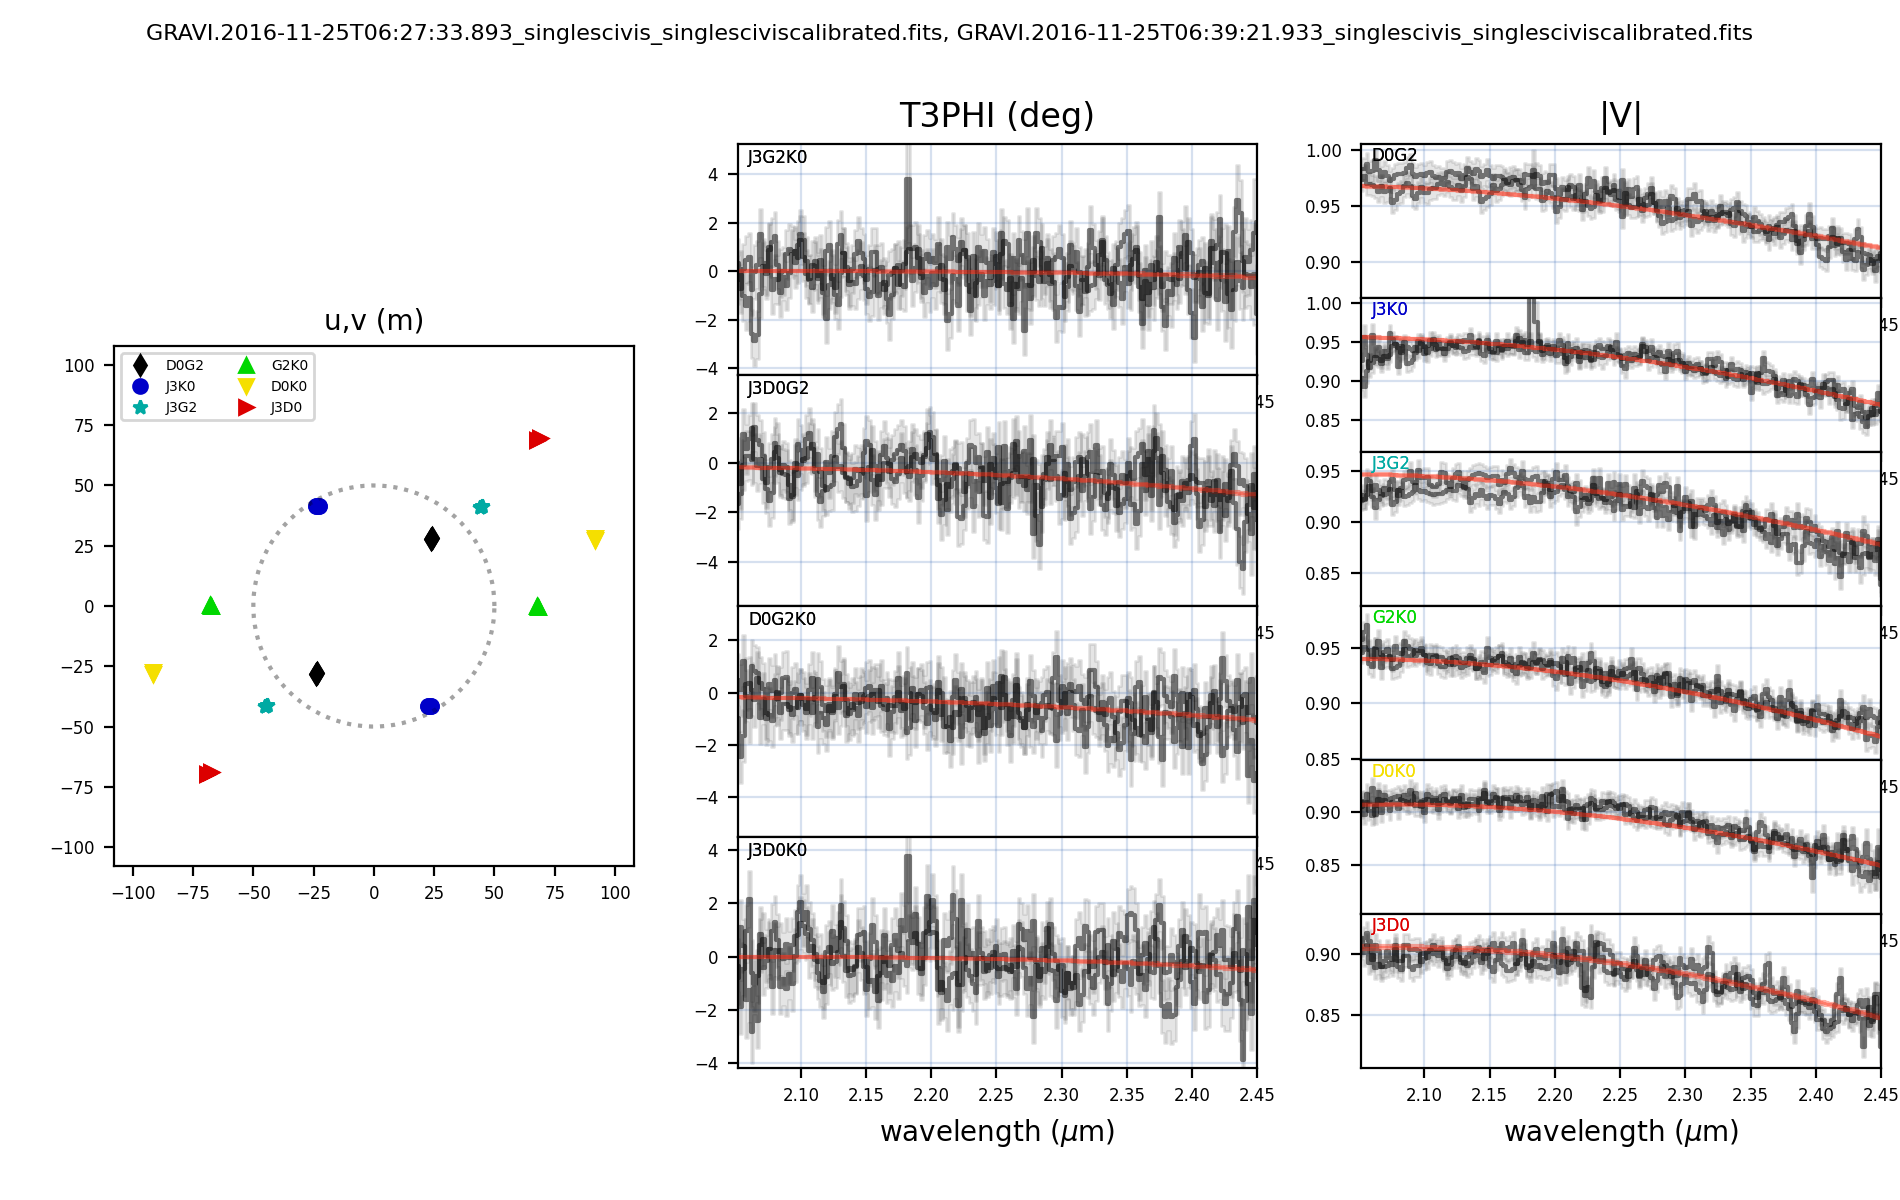

<IPython.core.display.Javascript object>


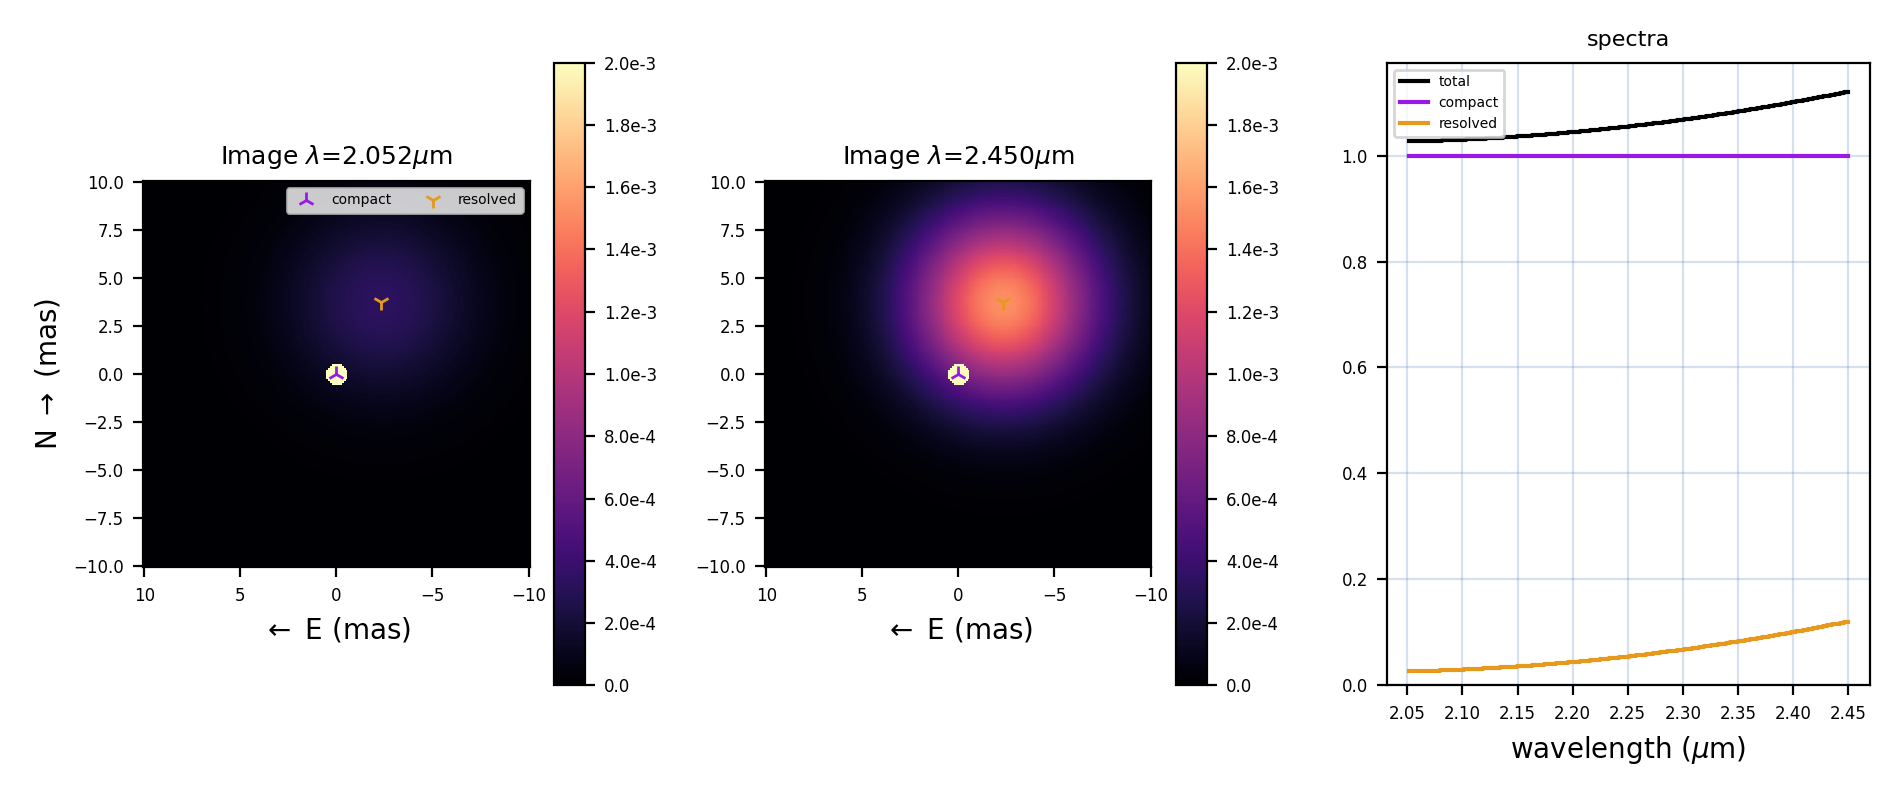

done in 1.25s


In [3]:
# -- set the context for the fit
fit = {
    # -- observable to fit
    'obs': ['|V|','T3PHI'],
    # -- wavelength range: bluest part is very noisy
    'wl ranges':[(2.05, 2.5)],
    # -- minimum error, override the errors in data file
    'min error': {'T3PHI':1.0},
    'min relative error':{'|V|':0.01},
}

oi.setupFit(fit)

# -- first guess for the model
param = {'compact,f0':   1.0, # flux of compact component
         'compact,ud':   .5, # uniform disk diameter (mas)
         'resolved,F0':   0.05,  # resolved component flux
         'resolved,F2':   0.5, # resolved component flux in (lambda-min(lambda))**2
         'resolved,spectrum': '$F0 + $F2*($WL-2.0)**2',
         'resolved,fwhm': 8.0,  # resolved component has a gaussian profile, this is its full width half maximum (mas)
         'resolved,x':    0, # offset to E (mas)
         'resolved,y':    0, # offset to N (mas)
        }
doNotFit = ['compact,f0']

# -- using 'merged' because computations are faster:
oi.doFit(param, doNotFit=doNotFit)
# -- using 'data' will show each file separatly
oi.show(allInOne=1, imFov=20, imPix=0.1, imMax=0.002)

## Bootstrapping to get better uncertainties

Contrary to example 1 (Alpha Cen), here the boostrapped uncertainties are much larger that the ones estimated by a simple fit to all data. This is because the model is not robust, or that we do do not have enough data. We also chose to run more fits (`Nfits=200`) than the default number $40 = 2\times(2_\mathrm{files}*(6_\mathrm{V2} + 4_\mathrm{T3PHI}))$.

In [4]:
oi.bootstrapFit(Nfits=200)

running 200 fits...
one fit takes ~0.72s using 8 threads
it took 85.2s, 0.43s per fit on average
using 199 fits out of 200 (sigma clipping 4.50)
{'compact,f0'       :1.0
'compact,ud'       : 1.053, # +/- 0.035
'resolved,F0'      : 0.0252, # +/- 0.0032
'resolved,F2'      : 0.473, # +/- 0.012
'resolved,fwhm'    : 7.99, # +/- 0.33
'resolved,spectrum':'$F0 + $F2*($WL-2.0)**2'
'resolved,x'       : -2.13, # +/- 0.67
'resolved,y'       : 3.81, # +/- 0.59
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
                    0    1    2    3    4    5  
  0:   compact,ud #### -.85  .26 -.24 -.08 -.02 
  1:  resolved,F0 -.85 #### -.47  .38  .25  .06 
  2:  resolved,F2  .26 -.47 #### -.36 -.35 -.33 
  3:resolved,fwhm -.24  .38 -.36 ####  .12  .21 
  4:   resolved,x -.08  .25 -.35  .12 ####  .23 
  5:   resolved,y -.02  .06 -.33  .21  .23 #### 


<IPython.core.display.Javascript object>


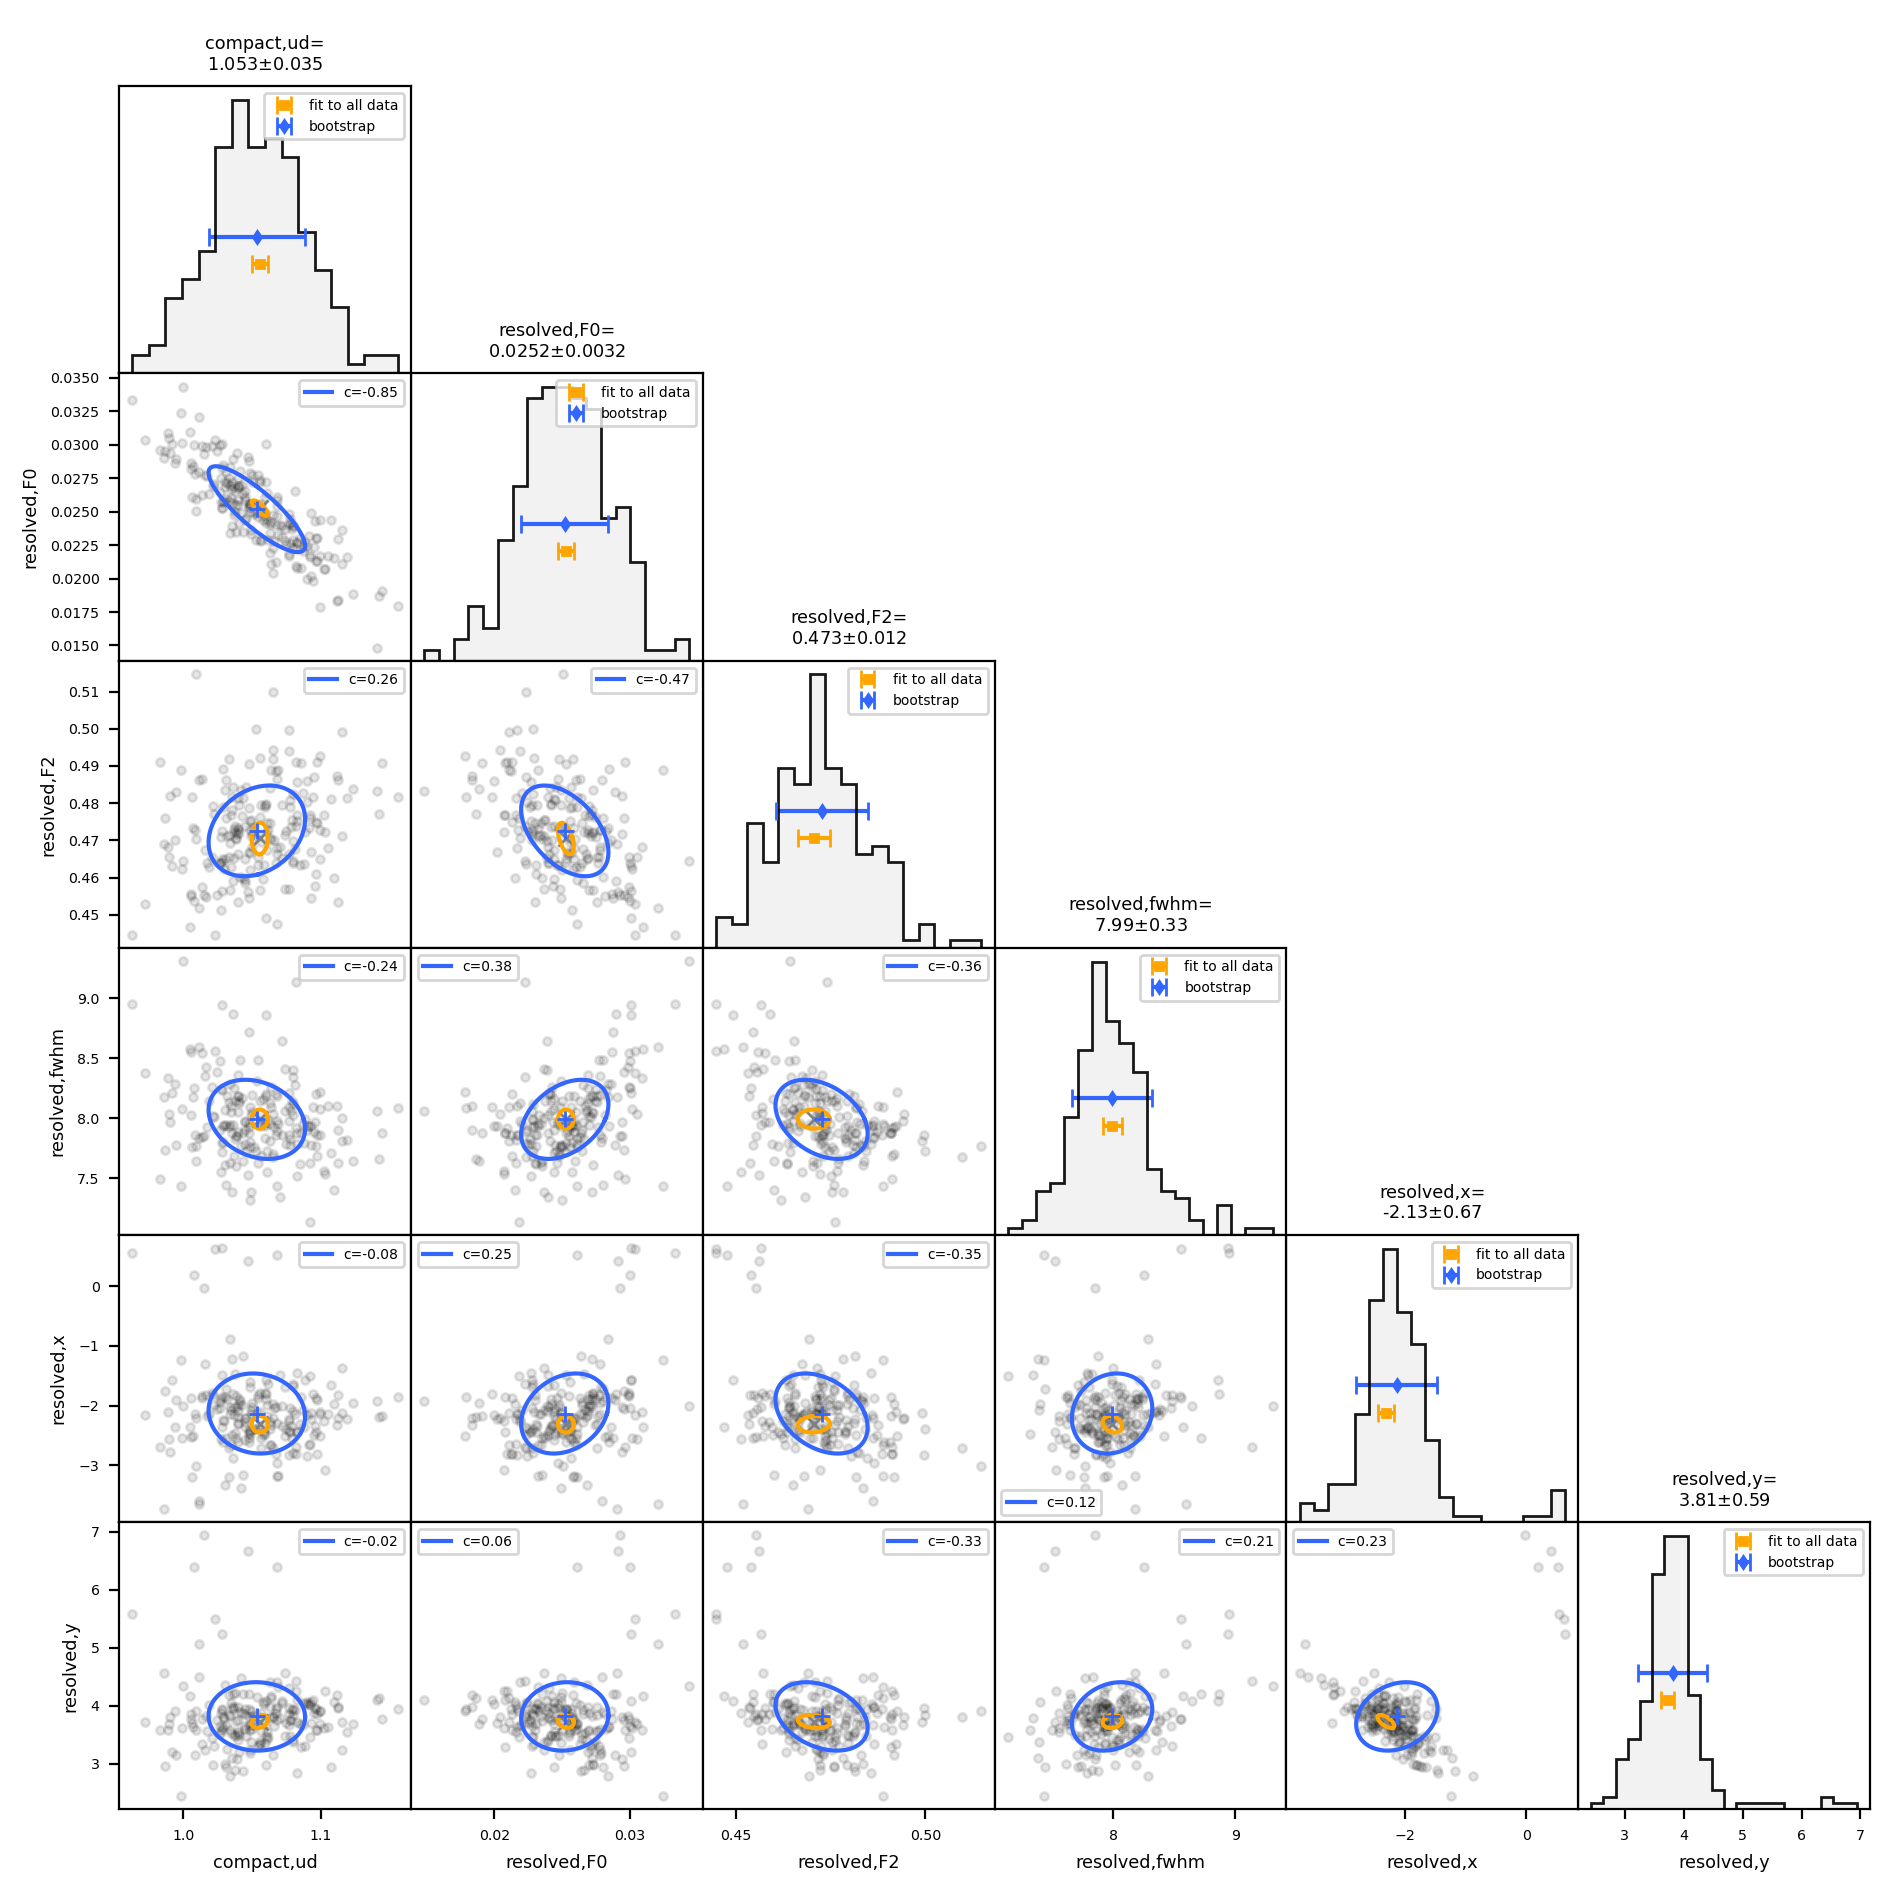

In [5]:
oi.showBootstrap()

## Alternate model, not in original paper
We still use 2 components. In order to create closure phase signal, the largest component has a slant rather than being off-centred.

[dpfit] 6 FITTED parameters: ['compact,ud', 'resolved,F0', 'resolved,F2', 'resolved,slant', 'resolved,slant projang', 'resolved,ud']
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb 22 16:04:27 2021     1 CHI2: 3.8490e+00|
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 38
[dpfit] time per function call: 20.17 (ms)
------------------------------
        CHI2= 3656.304741549682
REDUCED CHI2= 1.0066918341271152
------------------------------
(uncertainty normalized to data dispersion)

{'compact,f0':             1.0 ,
'compact,ud':             1.1267, # +/- 0.0049
'resolved,F0':            0.01893, # +/- 0.00051
'resolved,F2':            0.4614, # +/- 0.0041
'resolved,slant':         1.000, # +/- 0.086
'resolved,slant projang': 46.62, # +/- 4.75
'resolved,spectrum':      '$F0 + $F2*($WL-2.0)**2' ,
'resolved,ud':            14.37, # +/- 0.10
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
                

<IPython.core.display.Javascript object>


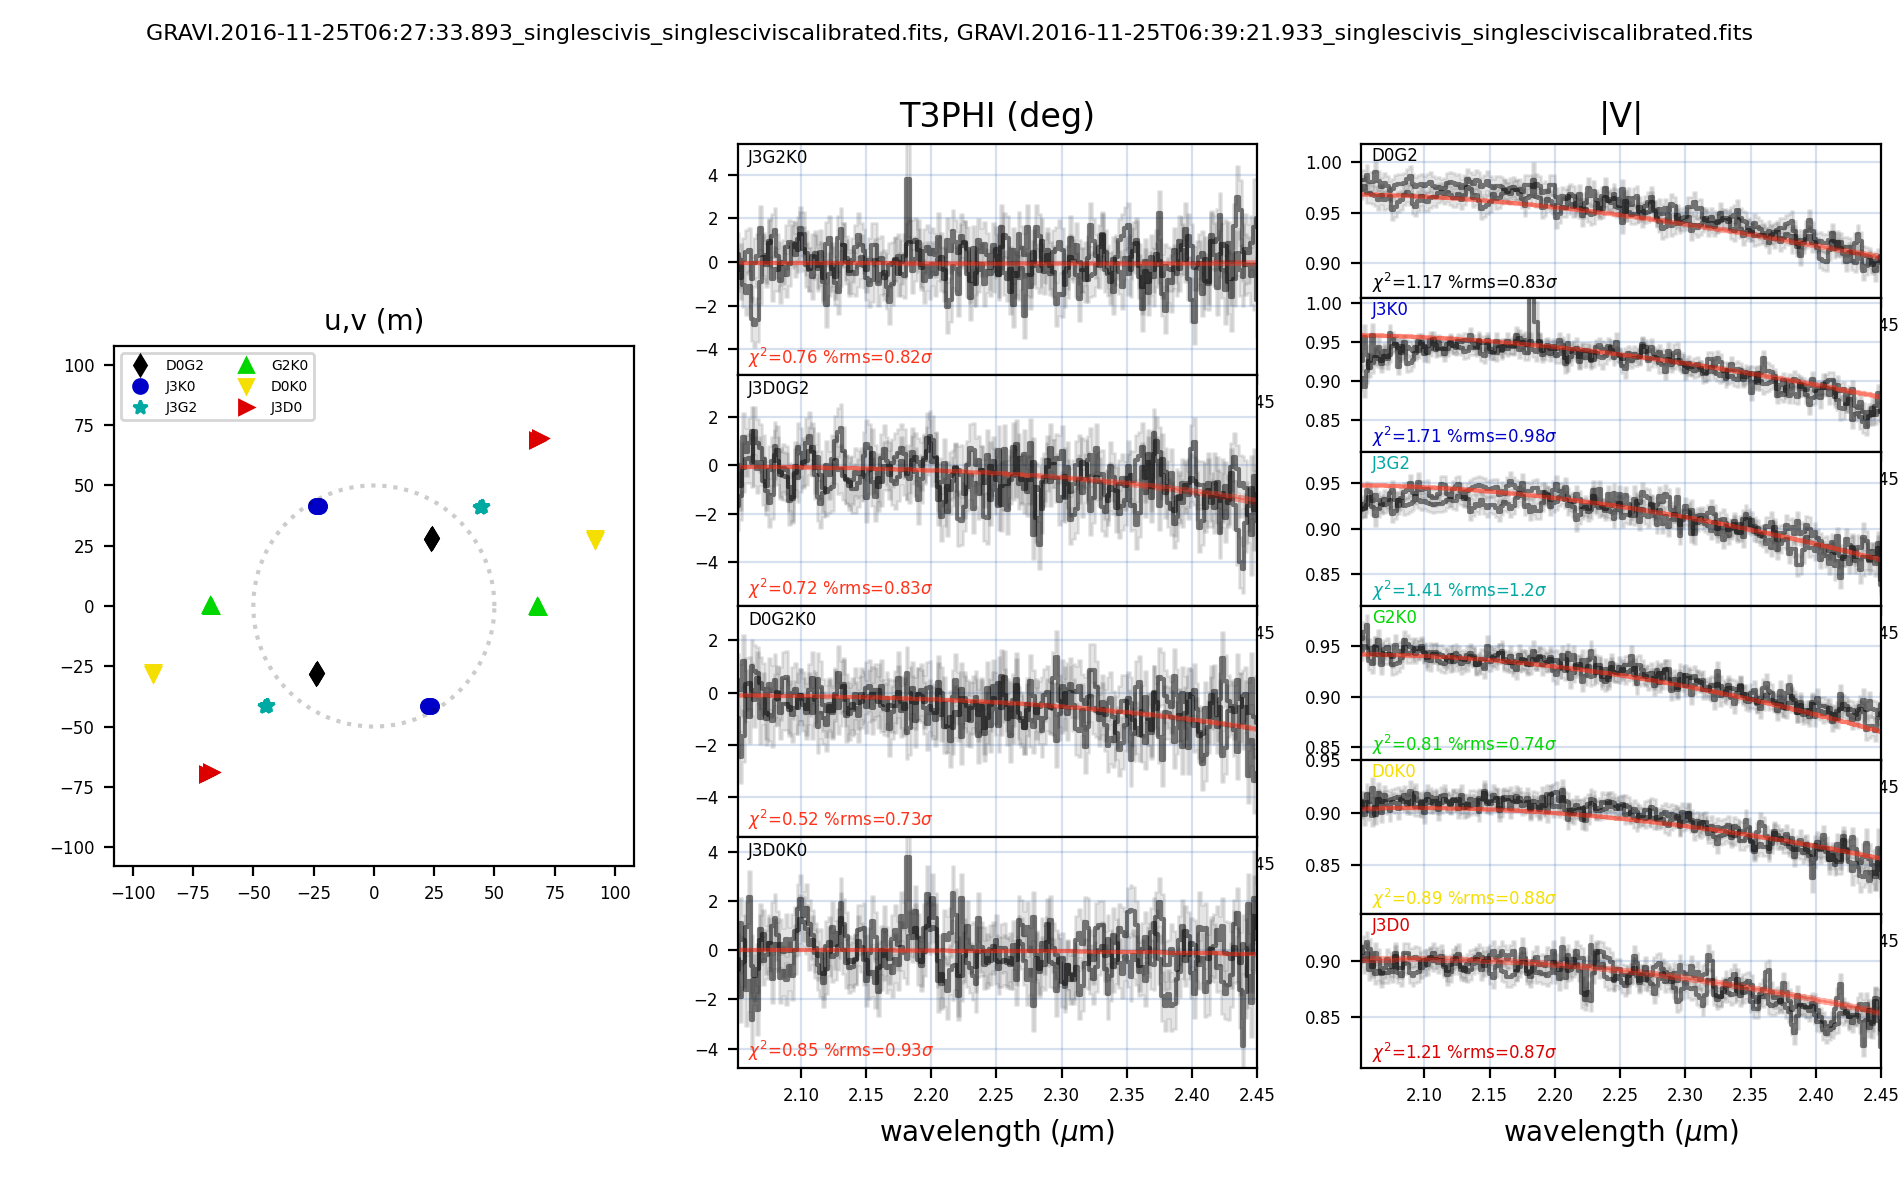

<IPython.core.display.Javascript object>


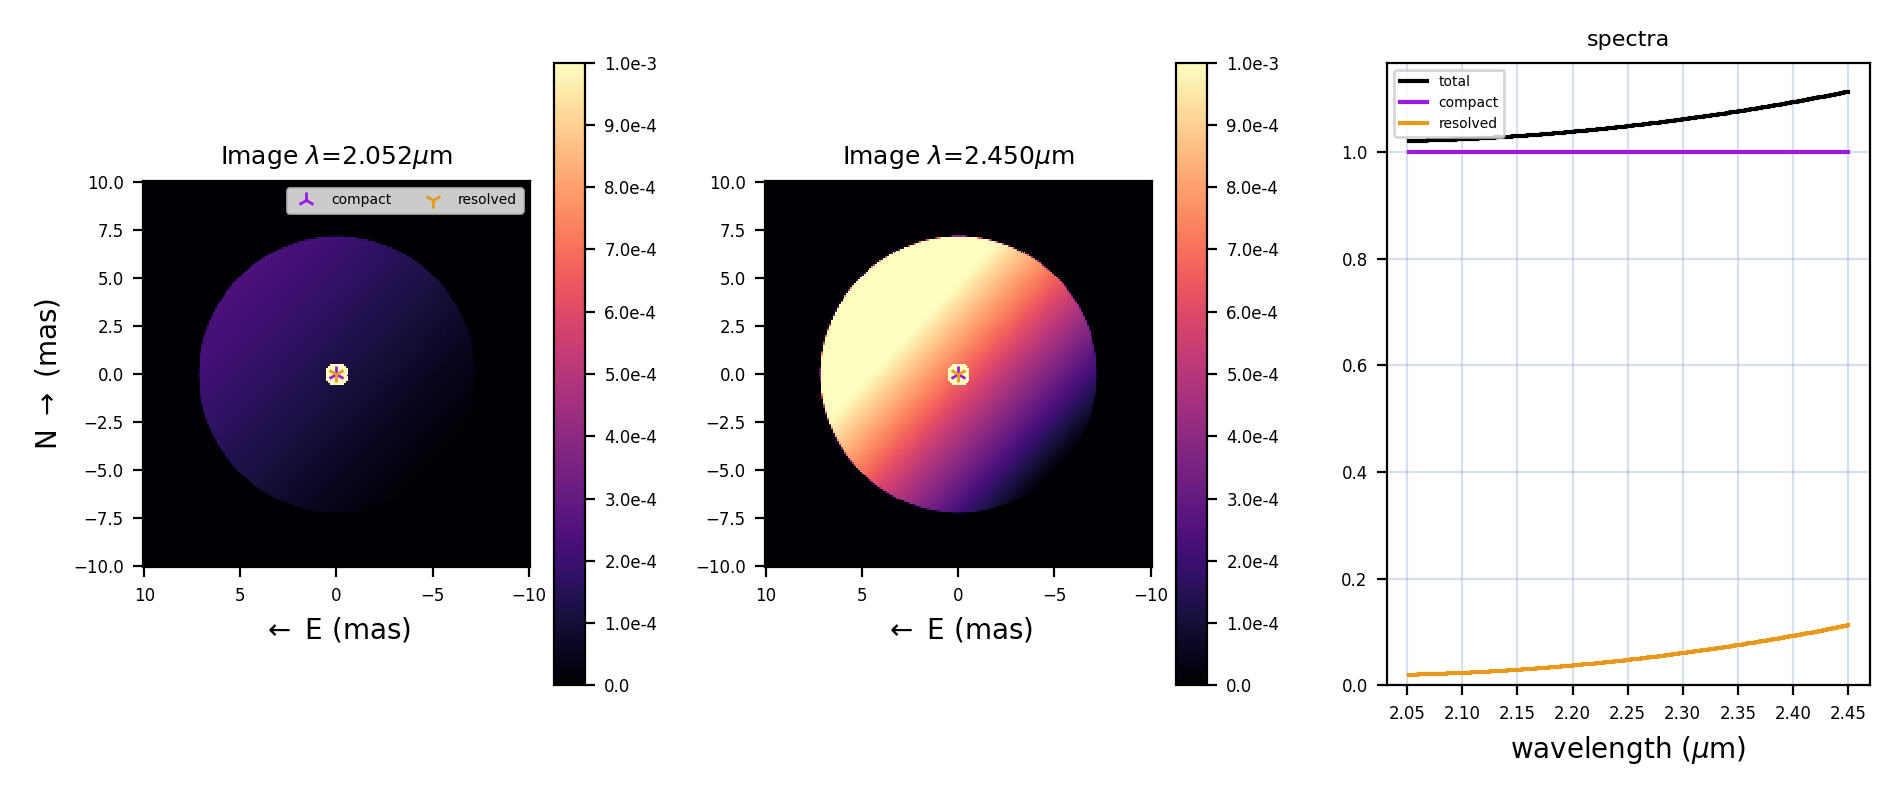

done in 0.91s


In [6]:
# -- set the context for the fit
fit = {
    # -- observable to fit
    'obs': ['|V|','T3PHI'],
    # -- wavelength range: bluest part is very noisy
    'wl ranges':[(2.05, 2.5)],
    # -- minimum error, override the errors in data file
    'min error': {'T3PHI':1.0},
    'min relative error':{'|V|':0.01},
}
oi.setupFit(fit)

param = {'compact,f0':       1.0 ,
         'compact,ud':       1, 
         'resolved,F0':   0.05,  
         'resolved,F2':   0.5, 
         'resolved,spectrum': '$F0 + $F2*($WL-2.0)**2',
          'resolved,slant':    0.5, 
          'resolved,slant projang': 0, 
          'resolved,ud':       10, 
        }
doNotFit = ['compact,f0']
oi.doFit(param, doNotFit=doNotFit)
oi.show(imFov=20, imPix=0.1, imMax=0.001)